<a href="https://colab.research.google.com/github/mongrelDS/time-series-study/blob/main/air_quality_time_series_model_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

part 1 wrangling data from source

part 2 autoregressive models

part 3 arma and hypermarameter tuning


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from os import rename

In [14]:
def wrangle(data, sensor_id=162):
  df=pd.read_csv(
      files,
      delimiter=';', 
      index_col= 5
      )
    
  #Localize timezone
  df.index = pd.to_datetime(df.index)
  df.index= df.index.tz_convert("Africa/Nairobi")

  # print(df['sensor_id'].describe())

  # Use rows where sensor id == 162 and reading type is P2. Remove all PS values above 500
  df=df[(df['sensor_id']==sensor_id) & (df['value_type']=='P2') & (df['value'] <500) ][['value']]

  # Label (rename) value column as P2
  df.rename(columns = {'value':'P2'}, inplace = True)

  # Resample to 1hr window
  y = df["P2"].resample("1H").mean().fillna(method='ffill')

  return y


In [15]:
files = '/content/drive/MyDrive/Public Data Projects/Air Quality Index/Nairobi/july_2022_sensor_data_archive.csv'
y= wrangle(files, sensor_id=162)
y.head()

timestamp
2022-07-01 03:00:00+03:00    3.782589
2022-07-01 04:00:00+03:00    3.040265
2022-07-01 05:00:00+03:00    3.362054
2022-07-01 06:00:00+03:00    5.019091
2022-07-01 07:00:00+03:00    8.025455
Freq: H, Name: P2, dtype: float64

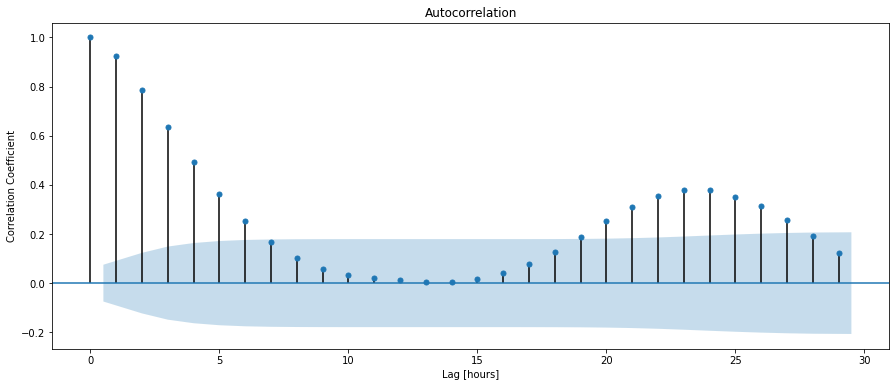

In [16]:
#ACF Plot

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)

plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

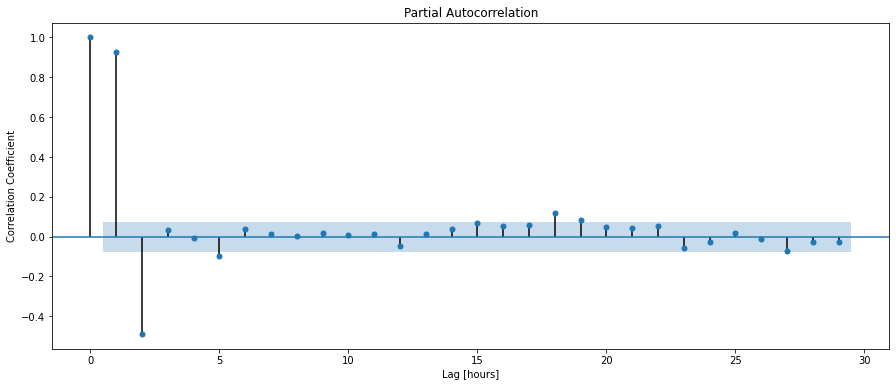

In [17]:
#PACF Plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [18]:
cutoff_test = int(len(y)*.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

In [19]:
len(y_train)+len(y_test)==len(y)

True

In [20]:
print(cutoff_test)

649


In [21]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 12.71
Baseline MAE: 5.78


In [22]:
model = AutoReg(y_train, lags=26).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [23]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 1.341967140125657


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [25]:
y_train_resid = model.resid
y_train_resid.tail()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


timestamp
2022-07-27 23:00:00+03:00    0.095215
2022-07-28 00:00:00+03:00   -2.022544
2022-07-28 01:00:00+03:00    0.409397
2022-07-28 02:00:00+03:00    0.706545
2022-07-28 03:00:00+03:00    0.199397
Freq: H, dtype: float64

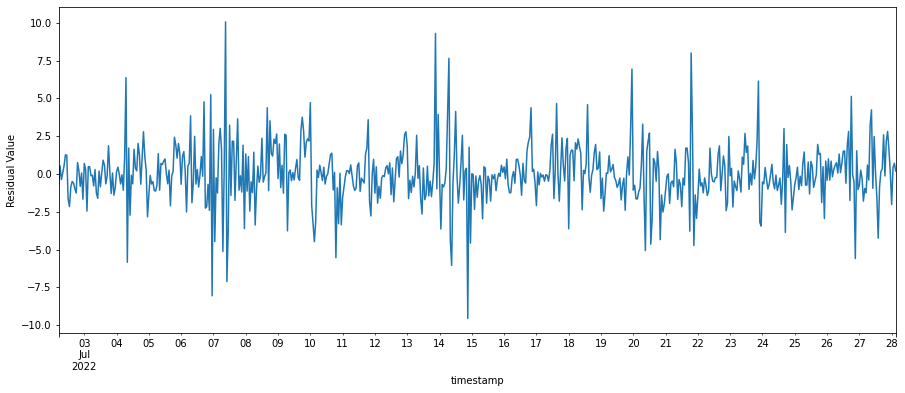

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax=ax)

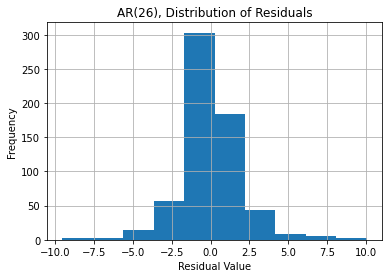

In [27]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution of Residuals");

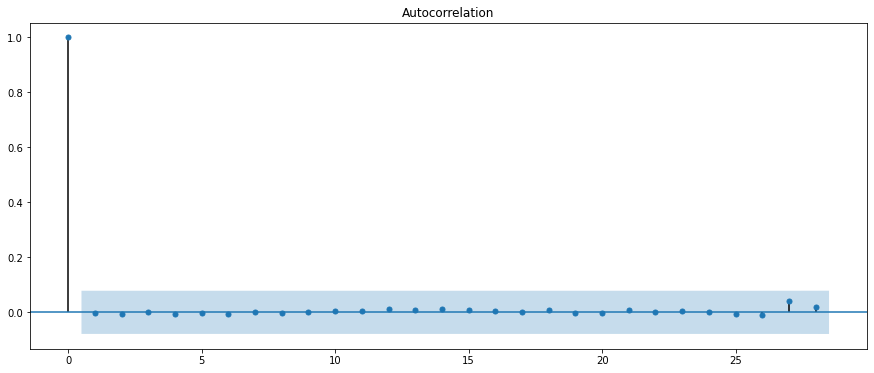

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

In [29]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 7.727548380512266


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [30]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [31]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

In [32]:
y_pred_wfv = pd.Series()
history = y_train.copy()       #adding one data point per iteration 
for i in range(len(y_test)):
    model = AutoReg(history,lags=26).fit()
    next_pred=model.forecast()
    y_pred_wfv= y_pred_wfv.append(next_pred)
    history= history.append(y_test[next_pred.index])

<ipython-input-32-a70b9c5c85a0>:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



In [33]:
len(y_pred_wfv)

35

In [34]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.94


In [35]:
print(model.params)

intercept    0.655323
P2.L1        1.508440
P2.L2       -0.812533
P2.L3        0.358905
P2.L4       -0.161998
P2.L5        0.023420
P2.L6       -0.049508
P2.L7        0.040768
P2.L8       -0.005264
P2.L9        0.009362
P2.L10      -0.048778
P2.L11       0.131001
P2.L12      -0.095179
P2.L13       0.038549
P2.L14      -0.113033
P2.L15       0.100200
P2.L16       0.010757
P2.L17      -0.075608
P2.L18       0.059795
P2.L19      -0.009036
P2.L20       0.068306
P2.L21      -0.108579
P2.L22       0.144675
P2.L23       0.001480
P2.L24      -0.148407
P2.L25       0.199653
P2.L26      -0.114954
dtype: float64


In [36]:
df_pred_test=pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}

)
fig = px.line(df_pred_test, labels={"value": "PM2.5"})
fig.show()